# t-tests in R


In this lesson, we will perform t-tests for individual regression parameters in R. To do this, we'll use a [dataset](https://dasl.datadescription.com/datafile/amazon-books/?_sfm_methods=Multiple+Regression&_sfm_cases=4+59943) about book prices from Amazon. The data consists of data on $n = 325$ books and includes measurements of:

- `aprice`: The price listed on Amazon (dollars)


- `lprice`: The book's list price (dollars)


- `weight`: The book's weight (ounces)


- `pages`: The number of pages in the book


- `height`: The book's height (inches)


- `width`: The book's width (inches)


- `thick`: The thickness of the book (inches)


- `cover`: Whether the book is a hard cover of paperback.


- And other variables...

We'll explore a model that will use `lprice`, `pages`, and `width` to predict `aprice`. But first, we'll do some work cleaning and wrangling the data.

## Data cleaning and wrangling

Let's read in the data and see if there are any missing values.

In [3]:
library(RCurl) #a package that includes the function getURL(), which allows for reading data from github.
library(ggplot2)
library(testthat)
url = getURL(paste0("https://raw.githubusercontent.com/bzaharatos/",
                    "-Statistical-Modeling-for-Data-Science-Applications/",
                    "master/Modern%20Regression%20Analysis%20/Datasets/amazon.txt"))
amazon = read.csv(text = url, sep = "\t")
names(amazon)
df = data.frame(aprice = amazon$Amazon.Price, lprice = as.numeric(amazon$List.Price),  
                pages = amazon$NumPages, width = amazon$Width, weight = amazon$Weight..oz,  
                height = amazon$Height, thick = amazon$Thick, cover = amazon$Hard..Paper)

summary(df)
which(is.na(df$lprice))

[1] "Title"        "Author"       "List.Price"   "Amazon.Price" "Hard..Paper" 
 [6] "NumPages"     "Publisher"    "Pub.year"     "ISBN.10"      "Height"      
[11] "Width"        "Thick"        "Weight..oz."

     aprice           lprice           pages           width      
 Min.   :  0.77   Min.   :  1.50   Min.   : 24.0   Min.   :4.100  
 1st Qu.:  8.60   1st Qu.: 13.95   1st Qu.:208.0   1st Qu.:5.200  
 Median : 10.20   Median : 15.00   Median :320.0   Median :5.400  
 Mean   : 13.33   Mean   : 18.58   Mean   :335.9   Mean   :5.585  
 3rd Qu.: 13.13   3rd Qu.: 19.95   3rd Qu.:416.0   3rd Qu.:5.900  
 Max.   :139.95   Max.   :139.95   Max.   :896.0   Max.   :9.500  
                  NA's   :1        NA's   :2       NA's   :5      
     weight          height           thick           cover          
 Min.   : 1.20   Min.   : 5.100   Min.   :0.1000   Length:325        
 1st Qu.: 7.80   1st Qu.: 7.900   1st Qu.:0.6000   Class :character  
 Median :11.20   Median : 8.100   Median :0.9000   Mode  :character  
 Mean   :12.49   Mean   : 8.163   Mean   :0.9077                     
 3rd Qu.:16.00   3rd Qu.: 8.500   3rd Qu.:1.1000                     
 Max.   :35.20   Max.   :12.100   Max.   :2.

[1] 205

From the summary, we can see that there are missing values in the dataset, coded as `NA`. There are many ways to deal with missing data. Suppose that sample unit $i$ has a missing measurement for variable $z_j$. We could:

1. Delete sample unit $i$ from the dataset, i.e., delete the entire row. That might be reasonable if there are very view missing values and if we think the values are missing at random.

2. Delete the variable $z_j$ from the dataset, i.e., delete the entire column. This might be reasonable if there are many many other missing values for $z_j$ and if we think $z_j$ might not be neccesary for our overall prediction/explanation goals.

3.  Impute missing values by substituting each missing value with an estimate.

For more information on missing values, see this [resource](https://www.bu.edu/sph/files/2014/05/Marina-tech-report.pdf).

Since most of our columns/variables are not missing values, and since these variables will be useful to us in our analysis, option 2 seems unreasonable. Let's first try option 3: impute the missing values of `lprice`, `pages`, `width`, `weight`, `height`, and `thick` with the mean of each.

In [2]:
df$lprice[which(is.na(df$lprice))] = mean(df$lprice, na.rm = TRUE)
df$weight[which(is.na(df$weight))] = mean(df$weight, na.rm = TRUE)
df$pages[which(is.na(df$pages))] = mean(df$pages, na.rm = TRUE)
df$height[which(is.na(df$height))] = mean(df$height, na.rm = TRUE)
df$width[which(is.na(df$width))] = mean(df$width, na.rm = TRUE)
df$thick[which(is.na(df$thick))] = mean(df$thick, na.rm = TRUE)
summary(df)

     aprice           lprice           pages           width      
 Min.   :  0.77   Min.   :  1.50   Min.   : 24.0   Min.   :4.100  
 1st Qu.:  8.60   1st Qu.: 13.95   1st Qu.:208.0   1st Qu.:5.200  
 Median : 10.20   Median : 15.00   Median :320.0   Median :5.400  
 Mean   : 13.33   Mean   : 18.58   Mean   :335.9   Mean   :5.585  
 3rd Qu.: 13.13   3rd Qu.: 19.95   3rd Qu.:416.0   3rd Qu.:5.900  
 Max.   :139.95   Max.   :139.95   Max.   :896.0   Max.   :9.500  
     weight          height           thick        cover  
 Min.   : 1.20   Min.   : 5.100   Min.   :0.1000   H: 89  
 1st Qu.: 7.80   1st Qu.: 7.900   1st Qu.:0.6000   P:236  
 Median :11.20   Median : 8.100   Median :0.9000          
 Mean   :12.49   Mean   : 8.163   Mean   :0.9077          
 3rd Qu.:16.00   3rd Qu.: 8.500   3rd Qu.:1.1000          
 Max.   :35.20   Max.   :12.100   Max.   :2.1000          

This removed the `NA` values, and substituted them with the mean of all the other values in the corresponding column. This isn't always a good idea, however. Let's take a look at a scatter plot of the Amazon price as a function of the list price (with points colored according to whether they are hardcover of paperback).

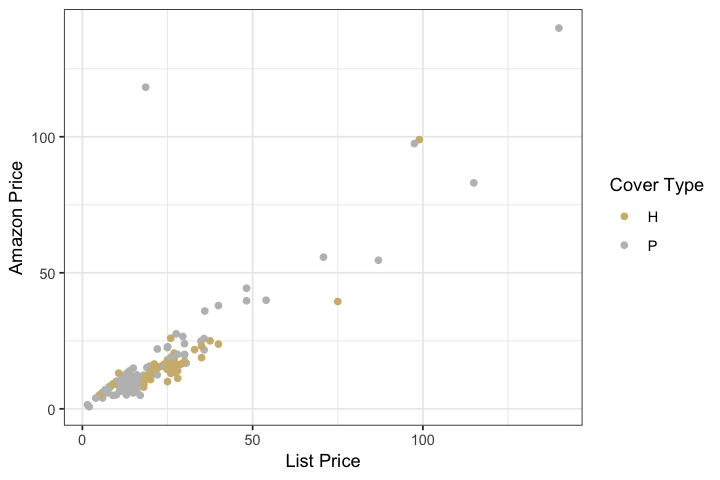

In [3]:
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(df) + 
    geom_point(aes(x = lprice, y = aprice, colour = cover)) +
    scale_colour_manual(name = 'Cover Type', values = setNames(c('#CFB87C','grey'),c("H", "P"))) +
    theme_bw() +
    xlab('List Price') + ylab('Amazon Price')

Arguably, there are many outliers here, but some of them won't really make a difference with respect to the fit of a linear model. However, one clearly will, namely the grey point that has a very high Amazon price and a relatively low list price. We might call this point an *influential point*, since it would influence the fit of the regression model. Let's see if this is the value that we imputed:

In [4]:
which(df$aprice >100 & df$lprice < 50)
amazon[205,]

[1] 205

Title             Author List.Price Amazon.Price Hard..Paper NumPages
205 The 80 10 10 Diet Graham NA         118.21       P           340     
    Publisher        Pub.year ISBN.10    Height Width Thick Weight..oz.
205 foodnsport Press 2006     1893831248 8.9    6     0.8   16

It is! This suggests that the imputation method probably did more harm than good, since it created a list price value that does not follow the trend in the data. Of course it's *possible* that this is the true list price for this book, but given that Amazon rarely has this much of a gap between its prices and list prices is a red flag! So instead, we'll remove the unit. Note though, that in a real data analysis, we should investigate the cause of the missing values, and perhaps try a more sophisticated imputation method if we think the values are not missing at random. Also, we should do similar explorations to see whether the other imputations that we performed cause similar problems. For now, we'll leave the other variables as is.

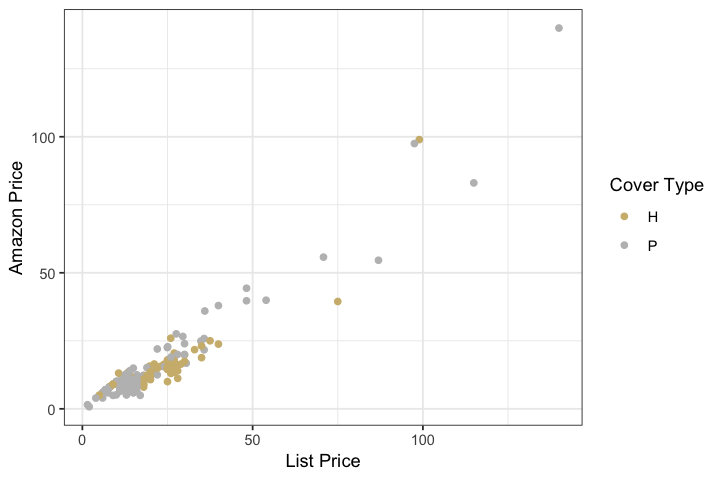

In [5]:
df = df[-205,]
options(repr.plot.width = 6, repr.plot.height = 4)
ggplot(df) + 
    geom_point(aes(x = lprice, y = aprice, colour = cover)) +
    scale_colour_manual(name = 'Cover Type', values = setNames(c('#CFB87C','grey'),c("H", "P"))) +
    theme_bw() +
    xlab('List Price') + ylab('Amazon Price')

There's clearly a strong linear relationship between the two prices. Let's look at relationships between other variables.

corrplot 0.84 loaded


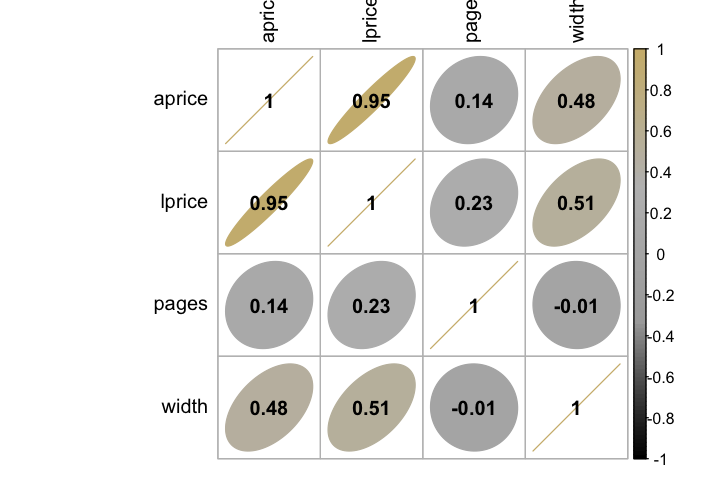

In [6]:
library(corrplot)
col4 = colorRampPalette(c("black", "darkgrey", "grey","#CFB87C"))
corrplot(cor(df[,1:4]), method = "ellipse", col = col4(100),  addCoef.col = "black", tl.col = "black")

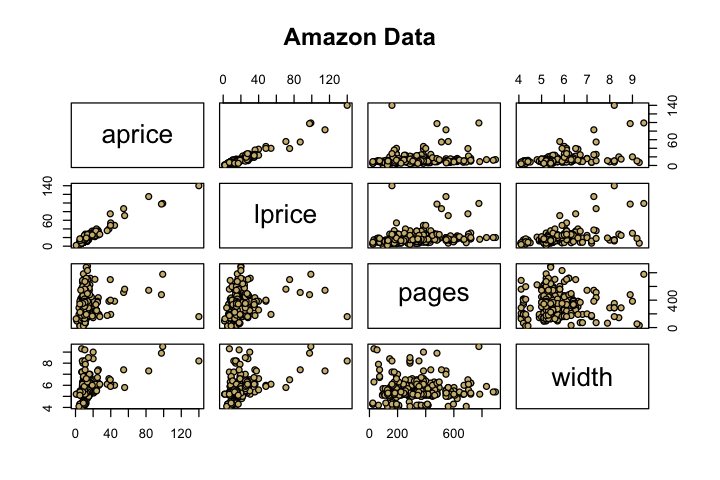

In [7]:
pairs(df[,1:4], main = "Amazon Data", pch = 21, 
      bg = c("#CFB87C"))

Some appear linear, but outliers exist. In a full analysis, we would work on identifying those outliers and decide why they were so different than other measurements. For the purposes of learning something about statistical inference in regression, we'll continue with the data as is; but note that outliers can impact statistical significance.

## Linear modeling

**Let's model the Amazon price as a function of the list price, the number of pages, and the width of the book. When conducting hypothesis tests, let's set $\alpha = 0.05$.**

In [18]:
lm_amazon = lm(aprice ~ lprice + pages + width, data = df)
summary(lm_amazon)


Call:
lm(formula = aprice ~ lprice + pages + width, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.7234  -1.7914  -0.1009   1.3386  22.2176 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.909076   1.567584   0.580    0.562    
lprice       0.860675   0.017850  48.217  < 2e-16 ***
pages       -0.005950   0.001358  -4.382 1.61e-05 ***
width       -0.326357   0.284143  -1.149    0.252    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.748 on 313 degrees of freedom
  (8 observations deleted due to missingness)
Multiple R-squared:  0.9118,	Adjusted R-squared:  0.9109 
F-statistic:  1078 on 3 and 313 DF,  p-value: < 2.2e-16


In [1]:
### BEGIN HIDDEN TESTS
lm_amazon_solution = lm(aprice ~ lprice + pages + width, data = df)
b = coef(lm_amazon)
b_solution = coef(lm_amazon_solution)

### END HIDDEN TESTS

ERROR: Error in model.frame.default(formula = aprice ~ lprice + pages + width, : 'data' must be a data.frame, environment, or list


Let $\beta_{width}$ be the parameter associated with the `width` predictor. Consider the hypothesis test:

$$H_0: \beta_{width} = 0 \,\,\, vs \,\,\, H_1: \beta_{width} \ne 0.$$

Notice that the p-value for this test is $0.285$, which is not less than $\alpha$. Thus, the parameter associated with `width` is not statistically significant at the $\alpha = 0.05$ level. As such, we do not have evidence that that parameter is different from zero, and, equivalently, we don't have statistical evidence to suggest that `width` should stay in the model.

Interestingly, the number of pages *is* statistically significant, but the *magnitude*, i.e., size of the association, of the parameter estimate is much lower than the estimate for the width:

$$\big| \, \widehat\beta_{pages}\, \big| = 0.006 < \big| \,  \widehat\beta_{width}\, \big|  = 0.326. $$

So, it may be that `pages` is statistically significant, but practically insignificant. To explore this, let's interpret the `pages` estimate: (assuming the model is roughly correct), adjusting for the list price and width, for every additional page added to a book, we can expect the amazon price to decrease by $\$0.006$, less than a penny. That is, an increase of 100 pages - a relatively large difference - is associated with a $\$0.60$ increase. Is this worth keeping in the model, even though it's *statistically* significant? It depends! Some important questions are:

1. Are researchers counting book pages themselves, and thus spending time and money on it, or is this page data easily available? 


2. How precise do our predictions need to be?

If researchers counting book pages themselves, and if predictions don't need to be all that precise, using `pages` as a predictor might be more trouble than it's worth! However, often, page information is available from publishers, and competing with Amazon prices might require a highly precise model. So, researchers might opt to keep `pages` in the model. In short, answering this question requires knowledge of the domain area and data collection process!

## F-tests in R

**Let's print the summary of the "full" model from above, namely, the model that includes `lprice`, `pages`, and `width` as predictors.**

In [7]:
summary(lm_amazon)


Call:
lm(formula = aprice ~ lprice + pages + width, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.3092  -1.7824  -0.0695   1.3374  22.9248 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.862994   1.573723   0.548    0.584    
lprice       0.854834   0.017848  47.895  < 2e-16 ***
pages       -0.006044   0.001348  -4.482 1.03e-05 ***
width       -0.305456   0.285426  -1.070    0.285    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.774 on 320 degrees of freedom
Multiple R-squared:  0.9089,	Adjusted R-squared:  0.908 
F-statistic:  1064 on 3 and 320 DF,  p-value: < 2.2e-16


First, note that the full F-test has a very large F-statistic ($1064$), and very small p-value ($2.2 \times 10^{-16}$, effectively zero). Typically, we should look at the full F-test first, to see if there is any evidence that any of the predictors are necesary in the model. Only after a significant full F-test should we look at an individual t-test.

We note again that the t-test associated with `width` is not significant, suggesting that there is no evidence that the parameter associated with `width` is different from zero. 

But even though `pages` is significant, it seems clear that `lprice` is most strongly associated with `aprice`. So, we might look at an F-test comparing the models:

$$H_0: Y_i = \beta_0 + \beta_{lprice} \left(lprice\right) + \varepsilon_i$$

with 

$$H_1: \text{number of pages or width (or both) should be included in the model. } $$

**Test these hypotheses in R and analyze the results.**

In [14]:
lm_amazon_reduced = lm(aprice ~ lprice, data = df)
anova(lm_amazon_reduced, lm_amazon)


Res.Df RSS      Df Sum of Sq F        Pr(>F)     
1 322    4846.160 NA       NA        NA          NA
2 320    4557.841  2 288.3194  10.12126 5.46791e-05

Note that the p-value associated with this partial F-test is small ($5.46791\times 10^{-5} < \alpha = 0.05$). This, we conclude that there is evidence that the reduced model is insufficient, and that we need at least one of the other predictors. We know that `width` is not statistically significant, and so we will only add back `pages`. This would leave us with the model 

$$Y_i = \beta_0 + \beta_{lprice} \left(lprice\right) + \beta_{pages} \left(pages\right)  + \varepsilon_i. $$



Interestingly, F-tests can be used when comparing two models that differ only by one predictor. For example, comparing 

$$\omega: Y_i = \beta_0 + \beta_{lprice} \left(lprice\right) + \beta_{pages} \left(pages\right)  + \varepsilon_i$$

with
 
 $$\Omega:Y_i = \beta_0 + \beta_{lprice} \left(lprice\right) + \beta_{pages} \left(pages\right) + \beta_{width} \left(width\right)  + \varepsilon_i.$$
 
Does the individual t-test and the F-test give consistent results? **Let's check**!


In [16]:
lm_amazon_reduced2 = lm(aprice ~ lprice + pages, data = df)
anova(lm_amazon_reduced2, lm_amazon)
summary(lm_amazon)

Res.Df RSS      Df Sum of Sq F        Pr(>F)   
1 321    4574.153 NA       NA        NA        NA
2 320    4557.841  1 16.31249  1.145279 0.2853462


Call:
lm(formula = aprice ~ lprice + pages + width, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.3092  -1.7824  -0.0695   1.3374  22.9248 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept)  0.862994   1.573723   0.548    0.584    
lprice       0.854834   0.017848  47.895  < 2e-16 ***
pages       -0.006044   0.001348  -4.482 1.03e-05 ***
width       -0.305456   0.285426  -1.070    0.285    
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.774 on 320 degrees of freedom
Multiple R-squared:  0.9089,	Adjusted R-squared:  0.908 
F-statistic:  1064 on 3 and 320 DF,  p-value: < 2.2e-16


Notice that the p-value for the individual t-test for the parameter associated with `width`, and the p-value for this partial F-test are the same! This is not an accident, but a consequence of the relationship between the t-distribution and the F-distribution: if $X \sim t(n)$ then $X^2 \sim F_{1,n}$.

In [20]:
summary(lm_amazon_reduced2)


Call:
lm(formula = aprice ~ lprice + pages, data = df)

Residuals:
     Min       1Q   Median       3Q      Max 
-19.0969  -1.8256  -0.0329   1.4436  23.3954 

Coefficients:
             Estimate Std. Error t value Pr(>|t|)    
(Intercept) -0.727973   0.516361  -1.410     0.16    
lprice       0.844690   0.015127  55.841  < 2e-16 ***
pages       -0.005824   0.001333  -4.369 1.69e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 3.775 on 321 degrees of freedom
Multiple R-squared:  0.9086,	Adjusted R-squared:  0.908 
F-statistic:  1595 on 2 and 321 DF,  p-value: < 2.2e-16
